## Описание задачи
## Тема «Промышленность»
Чтобы оптимизировать производственные расходы,  
металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали.  
Предстоит построить модель, которая предскажет температуру стали.  
Задача регрессионная: нужно предсказать количественный показатель.

<b>Описание этапа обработки</b>  
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн.  
Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом.  
Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.  

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы.  
Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).  
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ.  
Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом.  
Затем его перемешивают и снова проводят измерения.  
Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.  
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки.  
Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).  

<b>Описание данных</b>  
Данные состоят из файлов, полученных из разных источников:  
`data_arc.csv` — данные об электродах;  
`data_bulk.csv` — данные о подаче сыпучих материалов (объём);  
`data_bulk_time.csv` — данные о подаче сыпучих материалов (время);  
`data_gas.csv` — данные о продувке сплава газом;  
`data_temp.csv` — результаты измерения температуры;  
`data_wire.csv` — данные о проволочных материалах (объём);  
`data_wire_time.csv` — данные о проволочных материалах (время).  
Во всех файлах столбец `key` содержит номер партии.  
В файлах может быть несколько строк с одинаковым значением `key`:  
они соответствуют разным итерациям обработки.  

<b>Целевой признак</b>  
Конечная «Температура» файла `data_temp.csv`.

## Часть 1. План.
<b>Предобработка данных</b>
- Удалить ненужные данные.
- Привезти названия столбцов к стандартному виду.
- Обработать пропуски и выбросы.
- Убрать признаки, по которым было совсем незначительное количество данных по партиям.
- Добавить дополнительные признаки там, где это уместно.
- Подготовить финальные таблицы для объединения в общую таблицу для обучения моделей.

<b>Подготовка выборок</b>
- Выделить целевой признак.
- Разделить выборки на тренировочную и тестовую.

<b>Выбор моделей</b>
- Выбрать модели регрессии для теста.
- Подобрать параметры моделей.
- Выявить наиболее успешную модель.
- Получить целевой показатель `MAE` на тестовой выборке с успешной моделью.


## Часть 2. Анализ данных.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [2]:
data_arc = pd.read_csv('./datasets/data_arc_new.csv', parse_dates=[1, 2])
data_bulk = pd.read_csv('./datasets/data_bulk_new.csv')
data_bulk_time = pd.read_csv('./datasets/data_bulk_time_new.csv')
data_gas = pd.read_csv('./datasets/data_gas_new.csv')
data_temp = pd.read_csv('./datasets/data_temp_new.csv', parse_dates=[1])
data_wire = pd.read_csv('./datasets/data_wire_new.csv')
data_wire_time = pd.read_csv('./datasets/data_wire_time_new.csv')

RANDOM_STATE = 20220809

#### Выбор данных для анализа
Исходя из данных для анализа, решил оставить следующие:
- data_arc
- data_bulk
- data_gas
- data_temp
- data_wire

### Предобработка данных

Функция для отображения количества пропусков данных по столбцам.

In [3]:
def missing_values(df):
    percent_missing = round(df.isnull().sum() * 100 / len(df))
    percent_missing = percent_missing.astype(int)
    missing_value_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing}).sort_values(by='percent_missing')
    return missing_value_df

#### Данные об электродах

In [4]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [5]:
data_arc.head(5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


##### Новые названия столбцов

In [6]:
data_arc_columns = {
    'Начало нагрева дугой': 'arc_heating_start',
    'Конец нагрева дугой': 'arc_heating_finish',
    'Активная мощность': 'apparent_power',
    'Реактивная мощность': 'reactive_power',
}
data_arc = data_arc.rename(columns=data_arc_columns)

##### Полная мощность
Вычислим значение полной мощности S:  
Соотношение полной мощности с активной и реактивной мощностями выражается в следующем виде:  
$$ \sqrt[2]{P^2 + Q^2} $$  
<div style="text-align: center;">
<font size="4">  
, где P — активная мощность, Q — реактивная мощность

[wiki](https://ru.wikipedia.org/wiki/%D0%AD%D0%BB%D0%B5%D0%BA%D1%82%D1%80%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D0%BC%D0%BE%D1%89%D0%BD%D0%BE%D1%81%D1%82%D1%8C)


In [7]:
data_arc['real_power'] = (data_arc['apparent_power']**2 + data_arc['reactive_power']**2)**0.5

##### Общее время нагрева

In [8]:
data_arc['arc_heating_time'] = data_arc['arc_heating_finish'] - data_arc['arc_heating_start']
data_arc['arc_heating_time'] = data_arc['arc_heating_time'].dt.seconds

In [9]:
data_arc.tail(5)

,key,arc_heating_start,arc_heating_finish,apparent_power,reactive_power,real_power,arc_heating_time
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,0.532085,157
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,0.792429,180
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,1.293389,184
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,0.641792,57
14875,3241,2019-09-06 17:24:54,2019-09-06 17:26:15,0.389057,0.251347,0.463185,81


##### Количество раундов нагрева

In [10]:
heating_rounds = data_arc['key'].value_counts().reset_index(name='heating_rounds').rename(columns={'index': 'key'})

##### Обработка выбросов

In [11]:
sns.catplot(kind="box", data=data_arc[['apparent_power', 'reactive_power', 'real_power']], palette='viridis', height=5)
plt.title('Распределение мощностей', fontsize=14)
plt.xlabel('вид мощности')
plt.ylabel('значение')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'iteritems'

In [12]:
data_arc = data_arc.query('reactive_power > -100')

In [ ]:
sns.catplot(kind="box", data=data_arc[['apparent_power', 'reactive_power', 'real_power']], palette='viridis', height=5)
plt.title('Распределение мощностей', fontsize=14)
plt.xlabel('вид мощности')
plt.ylabel('значение')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'iteritems'

Удалю аномальное значение реактивной мощности

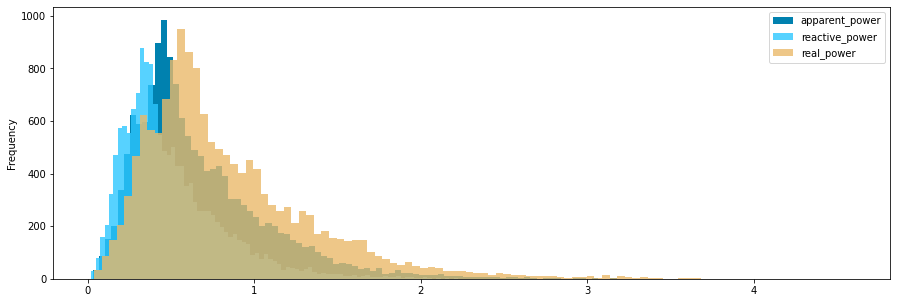

In [ ]:
plt.figure(figsize=(15, 5))
data_arc['apparent_power'].plot(kind='hist', bins=100, legend=True, color='#0081AF')
data_arc['reactive_power'].plot(kind='hist', bins=100, legend=True, color='#2DC7FF', alpha=0.8)
data_arc['real_power'].plot(kind='hist', bins=100, legend=True, color='#EABA6B', alpha=0.8)
plt.show()

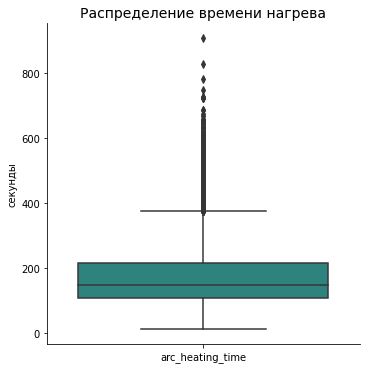

In [ ]:
sns.catplot(kind="box", data=data_arc[['arc_heating_time']], palette='viridis', height=5)
plt.title('Распределение времени нагрева', fontsize=14)
plt.ylabel('секунды')
plt.show()

In [13]:
data_arc.describe()

,key,arc_heating_start,arc_heating_finish,apparent_power,reactive_power,real_power,arc_heating_time
count,14875.000000,14875,14875,14875.000000,14875.000000,14875.000000,14875.000000
mean,1615.186756,2019-07-05 12:23:40.763025152,2019-07-05 12:26:32.438184960,0.662749,0.487115,0.823385,171.675160
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,0.153777,0.275718,11.000000
25%,806.000000,2019-06-03 23:13:02.500000,2019-06-03 23:16:13,0.467115,0.337190,0.578839,107.000000
50%,1617.000000,2019-07-03 01:28:12,2019-07-03 01:31:27,0.599578,0.441665,0.746554,147.000000
75%,2429.000000,2019-08-07 22:54:16.500000,2019-08-07 22:57:54,0.830135,0.608223,1.030402,214.000000
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284,1.898158,907.000000
std,934.593897,NaN,NaN,0.258894,0.197612,0.323470,98.188759


Остались выбросы, оставлю до получения результатов ошибки

##### Таблица с финальными признаками
Объединю значения по номеру партии, просуммировав значения

In [14]:
final_data_arc = data_arc.groupby(by = 'key').sum()
final_data_arc = final_data_arc.merge(heating_rounds, on='key')
final_data_arc.head(5)

TypeError: datetime64 type does not support sum operations

#### Данные о подаче сыпучих материалов (объём)

In [ ]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Бо́льшая часть сыпучих материалов добавляется всего в нескольких процентах партий.

In [ ]:
missing_values(data_bulk)

,column_name,percent_missing
key,key,0
Bulk 14,Bulk 14,10
Bulk 12,Bulk 12,22
Bulk 15,Bulk 15,28
Bulk 3,Bulk 3,59
Bulk 4,Bulk 4,68
Bulk 6,Bulk 6,82
Bulk 1,Bulk 1,92
Bulk 10,Bulk 10,94
Bulk 11,Bulk 11,94


In [ ]:
data_bulk.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


##### Новые названия столбцов

In [ ]:
data_bulk_columns = {
    'Bulk 1': 'bulk_1',
    'Bulk 2': 'bulk_2',
    'Bulk 3': 'bulk_3',
    'Bulk 4': 'bulk_4',
    'Bulk 5': 'bulk_5',
    'Bulk 6': 'bulk_6',
    'Bulk 7': 'bulk_7',
    'Bulk 8': 'bulk_8',
    'Bulk 9': 'bulk_9',
    'Bulk 10': 'bulk_10',
    'Bulk 11': 'bulk_11',
    'Bulk 12': 'bulk_12',
    'Bulk 13': 'bulk_13',
    'Bulk 14': 'bulk_14',
    'Bulk 15': 'bulk_15',
}
data_bulk = data_bulk.rename(columns=data_bulk_columns)

##### Обработка пропусков
Можно заполнить пропуски нулями, восстановить данные невозможно.

In [ ]:
data_bulk = data_bulk.fillna(0)

##### Тип данных столбцов `bulk_X`

In [ ]:
data_bulk = data_bulk.astype('int')

##### Таблица с финальными признаками
Отброшу материалы, у которых процент пропусков партий более 50%.

In [ ]:
final_data_bulk = data_bulk[['key', 'bulk_12', 'bulk_14', 'bulk_15']]
final_data_bulk.head(5)

,key,bulk_12,bulk_14,bulk_15
0,1,206,150,154
1,2,206,149,154
2,3,205,152,153
3,4,207,153,154
4,5,203,151,152


#### Данные о продувке сплава газом

In [ ]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [ ]:
data_gas.head(5)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [ ]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


##### Новые названия столбцов

In [ ]:
data_gas_columns = {
    'Газ 1': 'gas_1',
}
data_gas = data_gas.rename(columns=data_gas_columns)

##### Таблица с финальными признаками
Никаких изменений данных не требуется.

In [ ]:
final_data_gas = data_gas.copy()

#### Результаты измерения температуры

In [ ]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [ ]:
data_temp.head(5)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [ ]:
data_temp.describe()

,key,Время замера,Температура
count,18092.000000,18092,14665.000000
mean,1616.460977,2019-07-05 13:36:58.791620608,1590.722741
min,1.000000,2019-05-03 11:02:04,1191.000000
25%,807.750000,2019-06-04 00:35:01.249999872,1580.000000
50%,1618.000000,2019-07-03 02:11:48,1590.000000
75%,2429.000000,2019-08-07 23:10:05.249999872,1599.000000
max,3241.000000,2019-09-06 17:30:05,1705.000000
std,934.641385,NaN,20.394381


##### Новые названия столбцов

In [ ]:
data_temp_columns = {
    'Время замера': 'timestamp',
    'Температура': 'temperature',
}
data_temp = data_temp.rename(columns=data_temp_columns)

##### Обработка пропусков

In [ ]:
na = data_temp.isna().sum().sort_values(ascending=False)[0]/len(data_temp)
print(f'Количество пропусков, столбец "temperature": \n{na:.0%}')

Количество пропусков, столбец "temperature": 
18%


Пропусков довольно много, тем не менее удалю их

In [ ]:
data_temp = data_temp.dropna().reset_index(drop=True)
data_temp = data_temp.sort_values(by='timestamp')

In [ ]:
na = data_temp.isna().sum().sort_values(ascending=False)[0]/len(data_temp)
print(f'Проверка удаления пропусков: \n{na:.0%}')

Проверка удаления пропусков: 
0%


##### Тип данных столбца `temperature`

In [ ]:
data_temp['temperature'] = data_temp['temperature'].astype('int')

##### Обработка выбросов

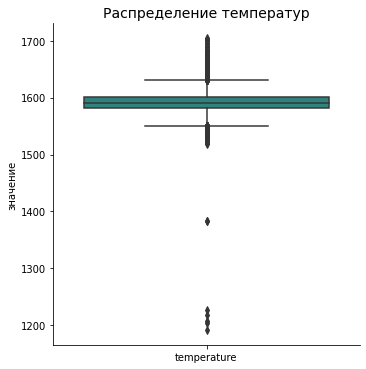

In [ ]:
sns.catplot(kind="box", data=data_temp[['temperature']], palette='viridis', height=5)
plt.title('Распределение температур', fontsize=14)
plt.ylabel('значение')
plt.show()

Уберу аномальные данные по температуре ниже 1400, их немного.

In [ ]:
data_temp = data_temp.query('temperature > 1400')

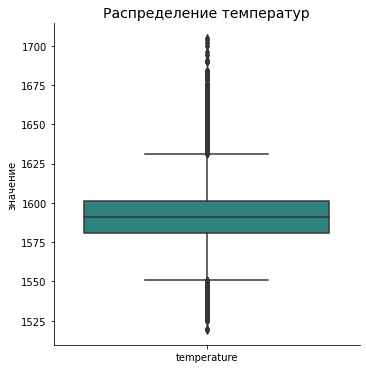

In [ ]:
sns.catplot(kind="box", data=data_temp[['temperature']], palette='viridis', height=5)
plt.title('Распределение температур', fontsize=14)
plt.ylabel('значение')
plt.show()

##### Количество раундов измерений

In [ ]:
measurements_rounds = data_temp['key'].value_counts().reset_index(name='measurements_rounds').rename(columns={'index': 'key'}).sort_values(by='key', ascending=False)

In [ ]:
measurements_rounds.query('measurements_rounds > 1').head(5)

,key,measurements_rounds
2373,2499,3
868,2498,5
2446,2497,2
1667,2496,4
2064,2495,3


С партии №2500 количество измерений равно единице.

##### Таблица с финальными признаками
Все замеры брать не имеет смысла: плохо скажется на обучении модели.  
Оставлю первый и последний замер.  
При этом на партиях 2500–3241 значения будут совпадать.  
Уберу партии, начиная с № 2500, так как отсутствуют данные по целевому признаку.  

Добавлю дополнительный признак: разницу между последним и первым замером температуры.

In [ ]:
final_data_temp = data_temp.groupby(by = 'key').agg(['first', 'last']).reset_index()
final_data_temp.columns = ['key', 'first_temp_ts', 'finish_temp_ts', 'first_temp', 'finish_temp']
final_data_temp['time_temp_diff'] = final_data_temp['finish_temp_ts'] - final_data_temp['first_temp_ts']
final_data_temp['time_temp_diff'] = final_data_temp['time_temp_diff'].dt.seconds
final_data_temp = final_data_temp.query('key < 2500')
final_data_temp.tail(5)

,key,first_temp_ts,finish_temp_ts,first_temp,finish_temp,time_temp_diff
2472,2495,2019-08-06 00:35:45,2019-08-06 00:54:42,1570,1591,1137
2473,2496,2019-08-06 01:02:54,2019-08-06 01:29:52,1554,1591,1618
2474,2497,2019-08-06 01:41:53,2019-08-06 01:53:50,1571,1589,717
2475,2498,2019-08-06 02:03:49,2019-08-06 02:25:31,1591,1594,1302
2476,2499,2019-08-06 02:40:25,2019-08-06 03:00:28,1569,1603,1203


#### Данные о проволочных материалах (объём)

In [ ]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [ ]:
missing_values(data_wire)

,column_name,percent_missing
key,key,0
Wire 1,Wire 1,1
Wire 2,Wire 2,65
Wire 3,Wire 3,98
Wire 6,Wire 6,98
Wire 8,Wire 8,99
Wire 9,Wire 9,99
Wire 4,Wire 4,100
Wire 5,Wire 5,100
Wire 7,Wire 7,100


In [ ]:
data_wire.head(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Новые названия столбцов

In [ ]:
data_wire_columns = {
    'Wire 1': 'wire_1',
    'Wire 2': 'wire_2',
    'Wire 3': 'wire_3',
    'Wire 4': 'wire_4',
    'Wire 5': 'wire_5',
    'Wire 6': 'wire_6',
    'Wire 7': 'wire_7',
    'Wire 8': 'wire_8',
    'Wire 9': 'wire_9',
}
data_wire = data_wire.rename(columns=data_wire_columns)

##### Обработка пропусков
Можно заполнить пропуски нулями, восстановить данные невозможно.

In [ ]:
data_wire = data_wire.fillna(0)

##### Таблица с финальными признаками
Отброшу материалы, у которых процент пропусков партий более 50%.

In [ ]:
final_data_wire = data_wire[['key', 'wire_1']]
final_data_wire.head(5)

,key,wire_1
0,1,60.059998
1,2,96.052315
2,3,91.160157
3,4,89.063515
4,5,89.238236


***
#### Вывод
- Привёл названия столбцов к стандартному виду.
- Обработал пропуски и выбросы.
- Убрал признаки, по которым было совсем незначительное количество данных по партиям.
- Выявил закономерность, по которой ограничены данные целевого признака для партий, начиная с номера 2500.  
    Так как это целевой признак, будут проблемы с целевым показателем MAE, убрал данные по проблемным партиям.
- Добавил дополнительные признаки там, где это показалось уместным.
- Подготовил финальные таблицы для объединения в общую таблицу для обучения моделей.<br><br>
***

### Создание общей таблицы для работы моделей
Исходя из данных для анализа, решил оставить следующие:
- data_arc
- data_bulk
- data_gas
- data_temp
- data_wire

In [ ]:
data = final_data_arc.merge(final_data_bulk, on='key', how='left')
data = data.merge(final_data_gas, on='key', how='left')
data = data.merge(final_data_temp, on='key', how='left')
data = data.merge(final_data_wire, on='key', how='left')

In [ ]:
len_data_na = len(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               3214 non-null   int64         
 1   apparent_power    3214 non-null   float64       
 2   reactive_power    3214 non-null   float64       
 3   real_power        3214 non-null   float64       
 4   arc_heating_time  3214 non-null   int64         
 5   heating_rounds    3214 non-null   int64         
 6   bulk_12           3128 non-null   float64       
 7   bulk_14           3128 non-null   float64       
 8   bulk_15           3128 non-null   float64       
 9   gas_1             3212 non-null   float64       
 10  first_temp_ts     2475 non-null   datetime64[ns]
 11  finish_temp_ts    2475 non-null   datetime64[ns]
 12  first_temp        2475 non-null   float64       
 13  finish_temp       2475 non-null   float64       
 14  time_temp_diff    2475 n

In [ ]:
data.describe()

,key,apparent_power,reactive_power,real_power,arc_heating_time,heating_rounds,bulk_12,bulk_14,bulk_15,gas_1,first_temp,finish_temp,time_temp_diff,wire_1
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3128.000000,3128.000000,3128.000000,3212.000000,2475.000000,2475.000000,2475.000000,3080.000000
mean,1623.061294,3.102984,2.317442,3.881975,794.545115,4.628500,204.013427,152.755435,115.356138,11.086159,1589.029899,1595.336162,1854.298586,100.044729
std,934.739859,1.397556,1.054316,1.740260,332.491076,1.608647,151.399912,81.058385,84.477031,6.176991,24.998058,16.023153,1301.178234,42.848073
min,1.000000,0.186226,0.158247,0.257637,57.000000,1.000000,0.000000,0.000000,0.000000,0.008399,1519.000000,1541.000000,234.000000,0.000000
25%,817.250000,2.126339,1.599018,2.674763,571.000000,4.000000,105.000000,104.000000,0.000000,7.096791,1572.000000,1587.000000,1182.500000,70.260839
50%,1623.500000,2.990537,2.229869,3.749955,770.000000,4.000000,206.000000,148.000000,106.000000,9.856023,1588.000000,1593.000000,1591.000000,100.133278
75%,2431.750000,3.901147,2.899141,4.858563,983.000000,6.000000,263.000000,202.000000,204.000000,13.808208,1605.000000,1599.000000,2261.000000,125.820243
max,3241.000000,17.496497,12.587990,21.564771,4189.000000,16.000000,1849.000000,636.000000,405.000000,77.995040,1679.000000,1700.000000,23537.000000,330.314424


In [ ]:
data.head(5)

,key,apparent_power,reactive_power,real_power,arc_heating_time,heating_rounds,bulk_12,bulk_14,bulk_15,gas_1,first_temp_ts,finish_temp_ts,first_temp,finish_temp,time_temp_diff,wire_1
0,1,4.878147,3.183241,5.826395,1098,5,206.0,150.0,154.0,29.749986,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,861.0,60.059998
1,2,3.052598,1.998112,3.649216,811,4,206.0,149.0,154.0,12.555561,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,1305.0,96.052315
2,3,2.525882,1.599076,2.989534,655,5,205.0,152.0,153.0,28.554793,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,1300.0,91.160157
3,4,3.209250,2.060298,3.814962,741,4,207.0,153.0,154.0,18.841219,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,388.0,89.063515
4,5,3.347173,2.252643,4.035758,869,4,203.0,151.0,152.0,5.413692,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,762.0,89.238236


#### Обработка пропусков
Удалю оставшиеся пропуски.

In [ ]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2474
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               2329 non-null   int64         
 1   apparent_power    2329 non-null   float64       
 2   reactive_power    2329 non-null   float64       
 3   real_power        2329 non-null   float64       
 4   arc_heating_time  2329 non-null   int64         
 5   heating_rounds    2329 non-null   int64         
 6   bulk_12           2329 non-null   float64       
 7   bulk_14           2329 non-null   float64       
 8   bulk_15           2329 non-null   float64       
 9   gas_1             2329 non-null   float64       
 10  first_temp_ts     2329 non-null   datetime64[ns]
 11  finish_temp_ts    2329 non-null   datetime64[ns]
 12  first_temp        2329 non-null   float64       
 13  finish_temp       2329 non-null   float64       
 14  time_temp_diff    2329 n

In [ ]:
na_proportion = (len_data_na - len(data)) / len(data)
print(f'Процент удалённых значений: {na_proportion:.1%}')

Процент удалённых значений: 38.0%


#### Удаление бесполезных признаков
Уберу признаки с типом `datetime64` и номер партии `key`.

In [ ]:
columns_to_drop = ['key', 'first_temp_ts', 'finish_temp_ts']
data = data.drop(columns=columns_to_drop)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2474
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   apparent_power    2329 non-null   float64
 1   reactive_power    2329 non-null   float64
 2   real_power        2329 non-null   float64
 3   arc_heating_time  2329 non-null   int64  
 4   heating_rounds    2329 non-null   int64  
 5   bulk_12           2329 non-null   float64
 6   bulk_14           2329 non-null   float64
 7   bulk_15           2329 non-null   float64
 8   gas_1             2329 non-null   float64
 9   first_temp        2329 non-null   float64
 10  finish_temp       2329 non-null   float64
 11  time_temp_diff    2329 non-null   float64
 12  wire_1            2329 non-null   float64
dtypes: float64(11), int64(2)
memory usage: 254.7 KB


#### Корреляция признаков

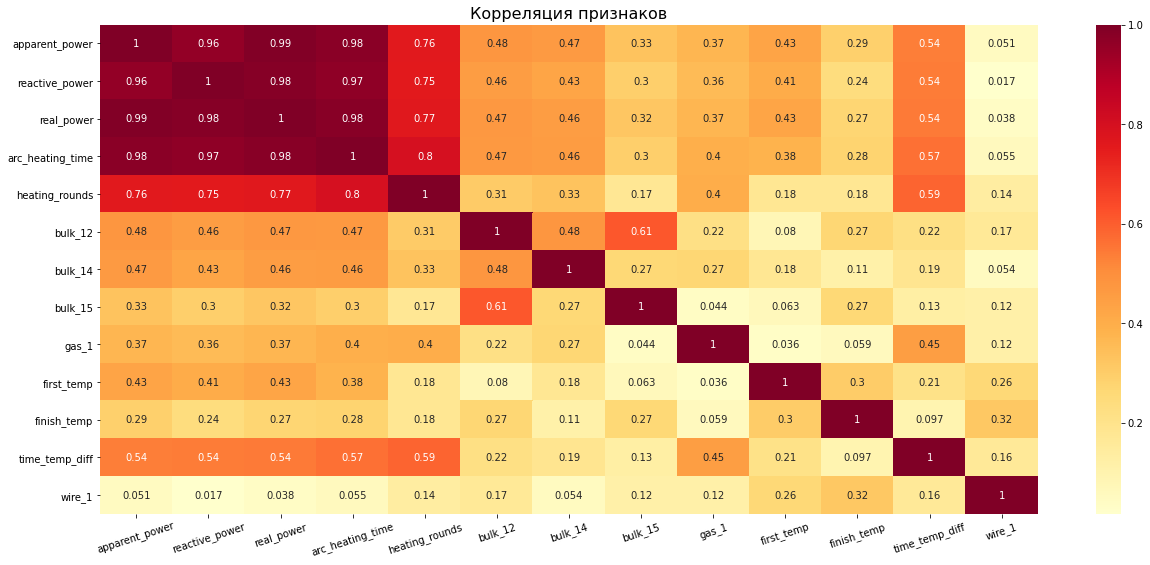

In [ ]:
plt.figure(figsize=(21, 9))
fig = sns.heatmap(data.corr().abs(), cmap='YlOrRd', annot=True)
plt.title('Корреляция признаков', fontsize=16)
plt.setp(fig.get_xticklabels(), rotation=18)
plt.show()

Высокая корреляция признаков между  
`apparent_power` / `reactive_power` / `real_power` / `arc_heating_time` / `heating_rounds`

***
#### Вывод по данным
- Привёл названия столбцов к стандартному виду.
- Обработал пропуски и выбросы.
- Убрал признаки, по которым было совсем незначительное количество данных по партиям.
- Выявил закономерность, по которой ограничены данные целевого признака для партий, начиная с номера 2500.  
    Так как это целевой признак, будут проблемы с целевым показателем MAE, убрал данные по проблемным партиям.
- Добавил дополнительные признаки там, где это показалось уместным.
- Подготовил финальные таблицы для объединения в общую таблицу для обучения моделей.
- Подготовил общую таблицу для обучения моделей.
- Удалил пропуски в общей таблице.
- Построил таблицу корреляции признаков.  
    Уберу признаки с высокой корреляцией, выявив наиболее важные при подборе параметров моделей.
- Не стал использовать `data_bulk_time` и `data_wire_time`, решил, что данные не будут полезны для обучения моделей.<br><br>
***

### Подготовка выборок

#### Выделение целевого признака

In [ ]:
features = data.drop(columns='finish_temp')
target = data['finish_temp']

#### Разделение на тренировочную и тестовую выборки

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, shuffle=True
)
print(
    f'Получились выборки в следующих пропорциях:\n'
    f'{(len(features_train)/len(data)):.0%} — тренировочная;\n'
    f'{(len(features_test)/len(data)):.0%} — тестовая.'
)

Получились выборки в следующих пропорциях:
75% — тренировочная;
25% — тестовая.


***
#### Вывод
- Выделил целевой признак.
- Разделил данные на тренировочную и тестовую.<br><br>
***

### Анализ данных

#### Выбор моделей
Попробую следующие модели:
- Линейная регрессия
- «Случайный лес»
- CatBoostRegressor
- LGBMRegressor

#### Линейная регрессия

In [ ]:
model = LinearRegression()
params = {
    'fit_intercept': [True, False],
}
lin_grid = GridSearchCV(model, params, cv=5, scoring='neg_mean_absolute_error')
lin_grid.fit(features_train, target_train)
result = abs(lin_grid.best_score_)
print(f'MAE (train): {result:.2f}')

MAE (train): 5.76


#### «Случайный лес»

In [ ]:
model = RandomForestRegressor()
params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 4, 8],
    'bootstrap': [True, False],
    'random_state': [RANDOM_STATE]
}
forest_grid = GridSearchCV(model, params, cv=5, scoring='neg_mean_absolute_error')
forest_grid.fit(features_train, target_train)
result = abs(forest_grid.best_score_)
print(f'MAE (train): {result:.2f}')

MAE (train): 5.98


#### CatBoostRegressor

In [ ]:
model = CatBoostRegressor(verbose=False)
params = {
    'loss_function':['MAE'],
    'depth': [5],  ## опробовано [5, 8, 10]
    'learning_rate': [0.1],  ## опробовано [0.01, 0.05, 0.1]
    'n_estimators': [500],  ## опробовано [100, 300, 500]
    'random_state': [RANDOM_STATE],
}
cat_grid = GridSearchCV(model, params, cv=5, verbose=2)
cat_grid.fit(features_train, target_train)
train_predictions = cat_grid.predict(features_train)
result = mean_absolute_error(target_train, train_predictions)
print(f'MAE (train): {result:.2f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END depth=5, learning_rate=0.1, loss_function=MAE, n_estimators=500, random_state=20220809; total time=   2.7s
[CV] END depth=5, learning_rate=0.1, loss_function=MAE, n_estimators=500, random_state=20220809; total time=   2.1s
[CV] END depth=5, learning_rate=0.1, loss_function=MAE, n_estimators=500, random_state=20220809; total time=   1.8s
[CV] END depth=5, learning_rate=0.1, loss_function=MAE, n_estimators=500, random_state=20220809; total time=   1.8s
[CV] END depth=5, learning_rate=0.1, loss_function=MAE, n_estimators=500, random_state=20220809; total time=   2.0s
MAE (train): 3.21


In [ ]:
cat_grid.best_params_

{'depth': 5,
 'learning_rate': 0.1,
 'loss_function': 'MAE',
 'n_estimators': 500,
 'random_state': 20220809}

#### LGBMRegressor

In [ ]:
model = LGBMRegressor()
params = {
    'metric': ['mae'],
    'max_depth': [10],  ## опробовано [5, 8, 10]
    'num_leaves': [10],  ## опробовано [10, 50, 100]
    'learning_rate': [0.05],  ## опробовано [0.001, 0.01, 0.03, 0.05]
    'random_state': [RANDOM_STATE],
}
lgbm_grid = GridSearchCV(model, params, cv=5, verbose=2)
lgbm_grid.fit(features_train, target_train)
train_predictions = lgbm_grid.predict(features_train)
result = mean_absolute_error(target_train, train_predictions)
print(f'MAE (train): {result:.2f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.05, max_depth=10, metric=mae, num_leaves=10, random_state=20220809; total time=   0.0s
[CV] END learning_rate=0.05, max_depth=10, metric=mae, num_leaves=10, random_state=20220809; total time=   0.0s
[CV] END learning_rate=0.05, max_depth=10, metric=mae, num_leaves=10, random_state=20220809; total time=   0.0s
[CV] END learning_rate=0.05, max_depth=10, metric=mae, num_leaves=10, random_state=20220809; total time=   0.0s
[CV] END learning_rate=0.05, max_depth=10, metric=mae, num_leaves=10, random_state=20220809; total time=   0.0s
MAE (train): 4.95


In [ ]:
lgbm_grid.best_params_

{'learning_rate': 0.05,
 'max_depth': 10,
 'metric': 'mae',
 'num_leaves': 10,
 'random_state': 20220809}

#### Метрика `CatBoostRegressor` на тестовых данных

MAE (test): 5.59


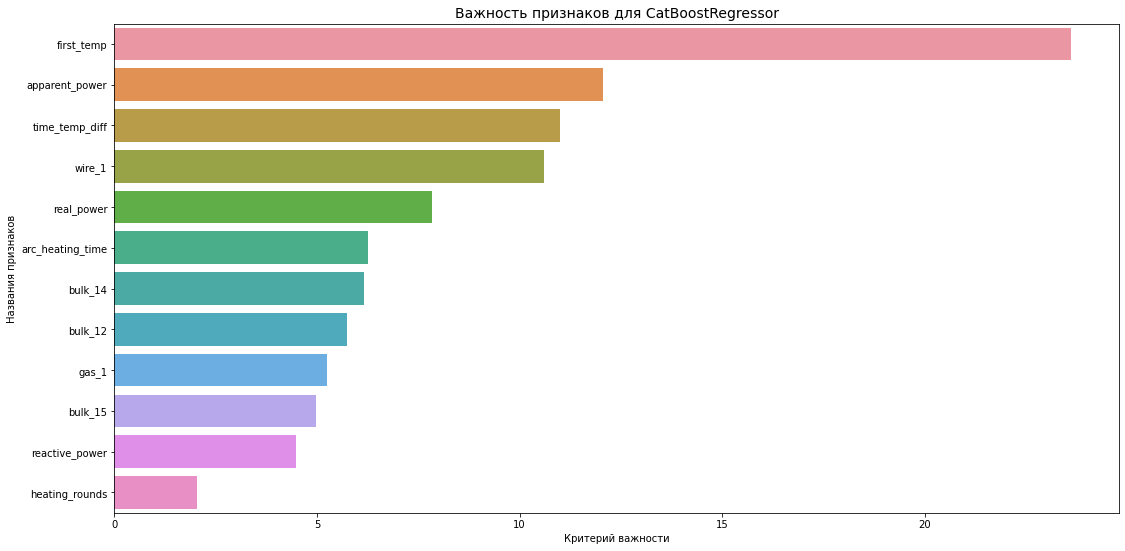

In [ ]:
model = CatBoostRegressor(
    depth=5,
    learning_rate=0.1,
    loss_function='MAE',
    n_estimators=500,
    random_state=20220809,
    verbose = False
)

model.fit(features_train, target_train)
predictions = model.predict(features_test)
result = mean_absolute_error(target_test, predictions)
print(f'MAE (test): {result:.2f}')

plot_data = {
    'features': features_test.columns,
    'feature_importances': model.feature_importances_,
}
plot_data = pd.DataFrame(plot_data)
plot_data.sort_values(by='feature_importances', ascending=False, inplace=True)
plt.figure(figsize=(18, 9))
sns.barplot(x=plot_data['feature_importances'], y=plot_data['features'])
plt.title('Важность признаков для CatBoostRegressor', fontsize=14)
plt.xlabel('Критерий важности')
plt.ylabel('Названия признаков')
plt.show()

Попробую отфильтровать данные, убрав `heating_rounds`, `reactive_power`, `arc_heating_time`,  
которые коррелируют с более важными `apparent_power` и `real_power`

In [ ]:
filt_features_train = features_train.copy()
filt_features_test = features_test.copy()
filt_features_train = filt_features_train.drop(columns=['heating_rounds', 'reactive_power', 'arc_heating_time'])
filt_features_test = filt_features_test.drop(columns=['heating_rounds', 'reactive_power', 'arc_heating_time'])

In [ ]:
model.fit(filt_features_train, target_train)
predictions = model.predict(filt_features_test)
result = mean_absolute_error(target_test, predictions)
print(f'MAE (test): {result:.2f}')

MAE (test): 5.50


Целевой показатель немного улучшился.

***
#### Часть 3. Отчёт.
- Для теста взял четыре модели, знакомые по прошлому обучению: Линейная регрессия, «Случайный лес», CatBoostRegressor, LGBMRegressor.
- Основные параметры, которые подбирались: глубина «дерева» (depth), скорость обучения (learning_rate), максимальное количество «деревьев» (n_estimators).
- Целевая метрика — средняя абсолютная ошибка (MAE) рассчитывается как сумма абсолютных ошибок, делённая на размер выборки.  
    Лучший показатель получился у модели CatBoostRegressor — 3.21 на тренировочных данных, 5.59 на тестовых и 5.5 после фильтрации признаков.
- При фильтрации признаков были убраны данные о проволочных материалах (время), о подаче сыпучих материалов (время).  
    Удалил признаки, которые не могут повлиять на обучение, данные о сыпучих и проволочных данных, использованные на крайне малом количестве партий.  
    На основе данных о корреляции признаков и важности признаков у финальной модели убрал признаки о количестве итераций нагрева (heating_rounds), реактивной мощности (reactive_power), времени нагрева электродами (arc_heating_time).  
    Из данных о важности признаков выделяется показатель начальной температуры, что логично говорит о том, что через влияние на начальную температуру можно влиять и на конечную.
- Признаки, которые попали в финальную таблицу:  
    apparent_power, real_power, bulk_12, bulk_14, bulk_15, gas_1, first_temp_ts, finish_temp_ts, first_temp, finish_temp, time_temp_diff, wire_1  
- По всем признакам привёл названия столбцов к стандартному виду, обработал пропуски и выбросы, убрал данные по проблемным партиям, у которых было мало данных по целевому признаку.
- Добавил дополнительные признаки там, где это показалось уместным.

<i>«Какие пункты плана были выполнены, а какие — нет (поясните почему)?»</i>  
    Все пункты плана удалось выполнить, сразу не удалось сообразить о том, что нужно будет проанализировать важность признаков итоговой модели и отфильтровать, исходя из параметров о корреляции признаков.

<i>«Какие трудности возникли и как вы их преодолели?»</i>  
    Было сложно разобраться в технологическом процессе и обилии, связи признаков во всех файлах.  
    Стало проще после консультации Николая, финальные штрихи подсказали другие ребята в Slack.

<i>«Какие ключевые шаги в решении задачи выделили?»</i>  
- Разбор технологического процесса.
- Консультация с экспертом.
- Обсуждение проблемных моментов с другими студентами.
- Изучение и предобработка входных данных.
- Подбор моделей для тестирования;  
    выбор метрики (в нашем случае была задана Николаем);  
    подбор лучших параметров, исходя из метрики.

<i>«Какая ваша итоговая модель и какое у неё качество?»</i>  
    Итоговая модель — CatBoostRegressor.  
    Показатель MAE на тестовых данных — 5.5.
<br><br>
***

***
### Общие выводы
- Привёл названия столбцов к стандартному виду.  
- Обработал пропуски и выбросы.  
- Убрал признаки, по которым было совсем незначительное количество данных по партиям.
- Выявил закономерность, по которой ограничены данные целевого признака для партий, начиная с номера 2500.  
    Так как это целевой признак, будут проблемы с целевым показателем MAE, убрал данные по проблемным партиям.
- Добавил дополнительные признаки там, где это показалось уместным.
- Подготовил финальные таблицы для объединения в общую таблицу для обучения моделей.
- По прошлому опыту решил проверить четыре модели: Линейная регрессия, «Случайный лес», CatBoostRegressor, LGBMRegressor.
- Лучший целевой показатель на тренировочных данных (MAE 3.24) показала модель CatBoostRegressor.
- После фильтрации признаков по соотношению важность / корелляция целевой показатель (MAE) на тестовых данных получился 5.5.  
    То есть модель ошибается на ≈ 5,5 градуса.
- Самые важные показатели: `first_temp`, `apparent_power`, `time_temp_diff`, `wire_1`.
- Получившийся результат проходит по условиям задачи MAE ≤ 6.0 (6 sp).  
    Допускаю, что можно улучшить результат за счёт лучшего подбора параметров, обработки выбросов.  
    Может быть имеет смысл попробовать ещё какие-то модели.<br><br>
***